# Testing the augmentation class 


In [29]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from pathlib import Path
import numpy as np
import rasterio


class ImageDataLoader:
    """
    This class prepares the tensorflow dataset for training:
    - Loads and processes the images and masks
    - Applies data augmentation: Flipping, Rotating, Adds noise, gaussian blur and zooming in.
    """

    def __init__(self, data_path):
        self.data_path = Path(data_path)
        self.base_path = self.data_path.parent
        self.satellite_dir = self.base_path / 'satellite'
        self.mask_dir = self.base_path / 'mask'

    def process_image(self, image_path):
        """
        Tensorflow function to process the satellite images for tensorflow datasets.
        :param image_path: A string of the image path
        :return: tensorflow compatible float32 image
        """

        def _load_image(path):
            with rasterio.open(path.decode("utf-8")) as src:
                image = src.read().transpose((1, 2, 0))
                return image.astype(np.float32)

        tensor = tf.numpy_function(_load_image, [image_path], tf.float32)
        tensor.set_shape([1024, 1024, 4])
        return tensor

    def process_mask(self, mask_path):
        """
        Tesnorflow function to process the masks for tensorflow datasets
        :param mask_path: A string of the mask path
        :return: tensorflow compatible uint8 image
        """

        def _load_mask(path):
            with rasterio.open(path.decode("utf-8")) as src:
                mask = src.read(1)
                mask = np.expand_dims(mask,
                                      -1)  # Adds a new dimension in the end of the array (height, width, channels=1)
                return mask.astype(np.uint8)

        tensor = tf.numpy_function(_load_mask, [mask_path], tf.uint8)
        tensor.set_shape([1024, 1024, 1])
        return tensor
    
    
    # Add the augmentation here:
    def add_horizontal_flip(self, image, mask):
        """
        Flip image horizontally
        """
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
        return image, mask
    
    def add_rotation(self, image, mask):
        """
        Rotate image by +- 90 degrees
        """
        rotation = [+1, -1]
        random_rotation = np.random.choice(rotation)
        image = tf.image.rot90(image, k=random_rotation)
        mask = tf.image.rot90(mask, k=random_rotation)
        return image, mask

    def add_gaussian_blur(self, image):
        """
        Apply gaussian blur to an already normalized image using scipy. 
        The function expects a tensorflow tensor and returns a blurred version of the image. 
        Each band is blurred independently to maintain spectral integrity.
        """
        def _apply_blur(image):
            # Define the standard deviation for the Gaussian Kernel: (Higher values will increase the blur)
            sigma = np.random.uniform(0.5, 1.5)
            blurred_image = np.zeros_like(image)
            for i in range(4):
                blurred_image[:, :, i] = gaussian_filter(image[:, :, i], sigma=sigma)
            return blurred_image.astype(np.float32)
        
        blurred_image = tf.numpy_function(_apply_blur, [image], tf.float32)
        blurred_image.set_shape([1024, 1024, 4])
        return blurred_image
    
     def add_speckle_noise(self, image):
        """Apply speckle noise to an already normalized image."""
        speckle_variance = np.random.uniform(0.01, 0.1)
        noise = tf.random.normal(shape=tf.shape(image), mean=1.0, stddev=tf.sqrt(speckle_variance))
        noisy_image = image * noise
        return noisy_image

    def add_gaussian_noise(self, image):
        """Apply gaussian noise to an already normalized image."""
        noise_variance = np.random.uniform(0.01, 0.1)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=tf.sqrt(noise_variance))
        noisy_image = image + noise
        return noisy_image

    def add_salt_and_pepper_noise(self, image):
        """
        Adds salt and pepper noise to an already normalized image.
        """
        noise_level = np.random.uniform(0.01, 0.1)
        shape = tf.shape(image)
        # Creates a tensors with the same size as the image with random values between 0 and 1:
        random_tensor = tf.random.uniform(shape, minval=0, maxval=1.0)

        # Creates a salt mask (white pixels) i.e. at 6% noise_level => 3% of the pixels will be white
        # Creates a mask with 0 and 1 values where 1 is the pixels that will be white
        salt_mask = tf.cast(random_tensor <= (noise_level / 2), image.dtype)
        # Creates a pepper mask (black pixels) i.e. at 6% noise_level => 3% of the pixels will be black
        # Creates a mask with 0 and 1 values where 1 is the pixels that will be black
        pepper_mask = tf.cast(random_tensor >= (1 - noise_level / 2), image.dtype)
        # Apply the masks to the image
        image_with_salt = tf.where(salt_mask == 1, tf.ones_like(image), image)
        noisy_image = tf.where(pepper_mask == 1, tf.zeros_like(image), image_with_salt)

        return noisy_image
    
    def augment(self, image, mask):
        
        # Adds a horizontal flip to the image and mask with a 50% probability
        if np.random.rand() > 0.5:
            image, mask = self.add_horizontal_flip(image, mask)
    
        # Adds a rotation to the image and mask with a 20% probability
        if np.random.rand() < 0.2:
            image, mask = self.add_rotation(image, mask)
    
        # Adds one of the following noises/blurs with a 50 % probability (Gaussian, speckle, salt and pepper, gaussian noise)
        if np.random.rand() > 0.5:
            noise_functions = [self.add_gaussian_noise, self.add_speckle_noise, self.add_salt_and_pepper_noise, self.add_gaussian_blur]
            noise_function = np.random.choice(noise_functions)
            image = noise_function(image)
        
        return image, mask
    
    def prepare_dataset(self, image_paths, mask_paths, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
        dataset = dataset.map(lambda x, y: (self.process_image(x), self.process_mask(y)),
                              num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(self.augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

    
 
            
    

In [30]:
image_paths = ["./data/satellite/AG_parcel_10.tif"]
mask_paths = ["./data/mask/AG_parcel_10_mask.tif"]

loader = ImageDataLoader("./data/")
dataset = loader.prepare_dataset(image_paths, mask_paths, batch_size=1)

Adding blur


Final image shape: (1, 1024, 1024, 4)
Final mask shape: (1, 1024, 1024, 1)


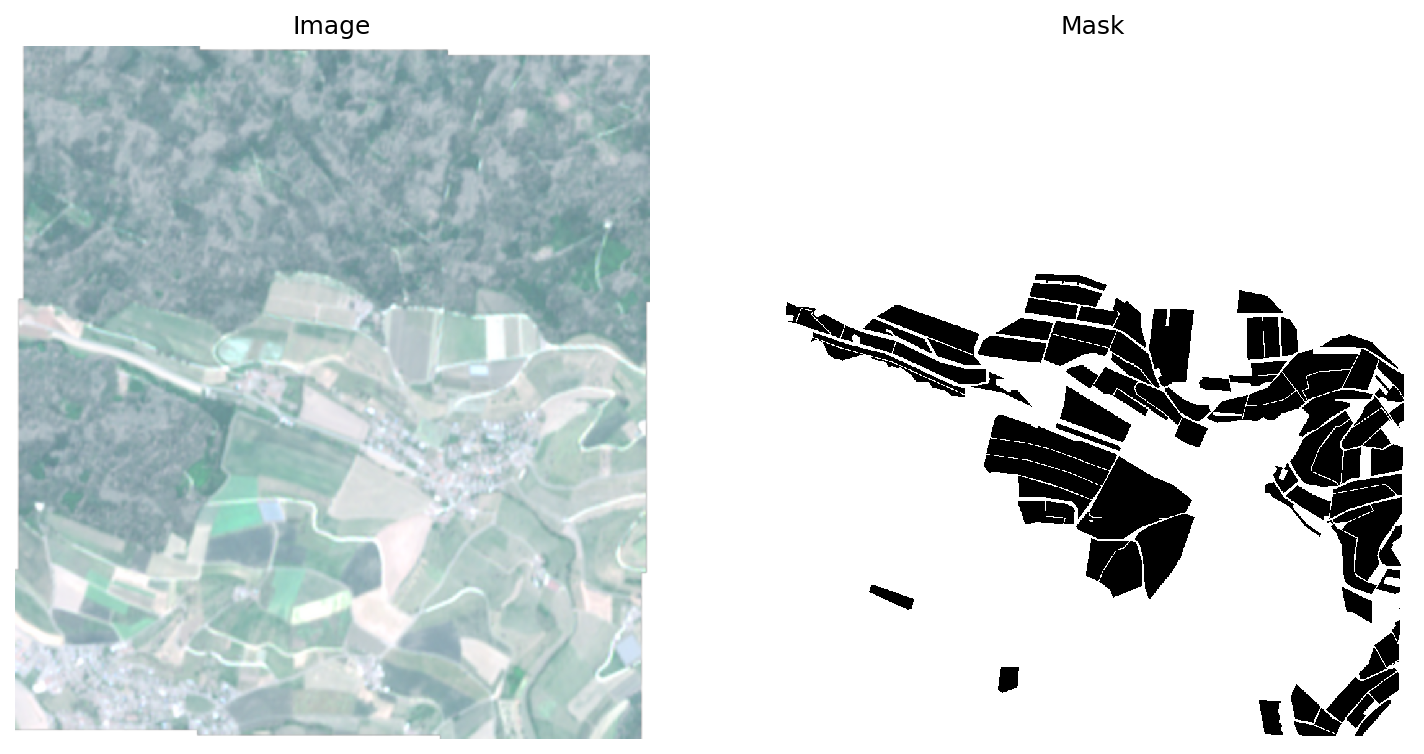

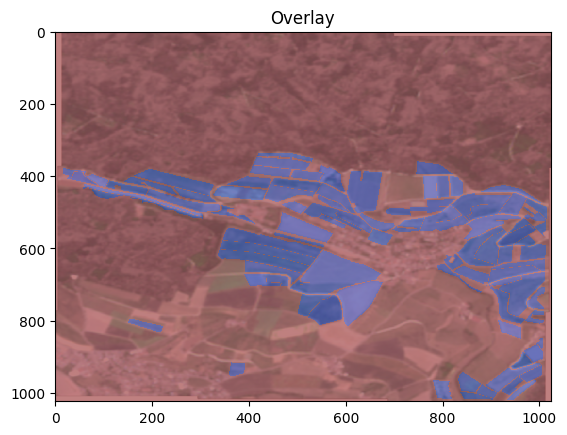

In [31]:
from matplotlib import pyplot as plt
for image, mask in dataset.take(1):
    print("Final image shape:", image.shape)
    print("Final mask shape:", mask.shape)
    image_np = image.numpy()  # Convert tensors to numpy arrays
    mask_np = mask.numpy()

    # Assuming image and mask are correctly shaped and scaled [0, 1] for visualization
    image_np = np.clip(image_np[0], 0, 1)  # Clip values to [0, 1] range and remove batch dimension
    mask_np = mask_np[0, :, :, 0]  # Remove batch dimension and channel dimension for mask

    plt.figure(figsize=(12, 6), dpi=150)  # Higher DPI
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, interpolation='nearest', aspect='auto')  # Adjust interpolation and aspect ratio
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray', interpolation='nearest', aspect='auto')
    plt.title("Mask")
    plt.axis('off')

    plt.show()
    
    # Lay the image and mask on top of each other
    plt.imshow(image_np, interpolation='nearest', aspect='auto')
    plt.imshow(mask_np, cmap='jet', alpha=0.5, interpolation='nearest', aspect='auto')
    plt.title("Overlay")
    
    plt.show()
    


    